In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
import time

## Dataset definition and visualization

(10000, 2)
[[ 0.59481822 -1.96308743]
 [ 1.59886243 -2.54806867]
 [-6.56760252  3.07748993]
 [-1.61316237 10.75894485]
 [ 3.13708409  4.51870108]
 [-6.6907856   3.74641659]
 [ 0.08383941 -1.57435027]
 [ 8.4942585   7.22526788]
 [-5.70602454  4.31298617]
 [-2.13129662 -1.73655867]]
[0 0 1 ... 4 4 1]


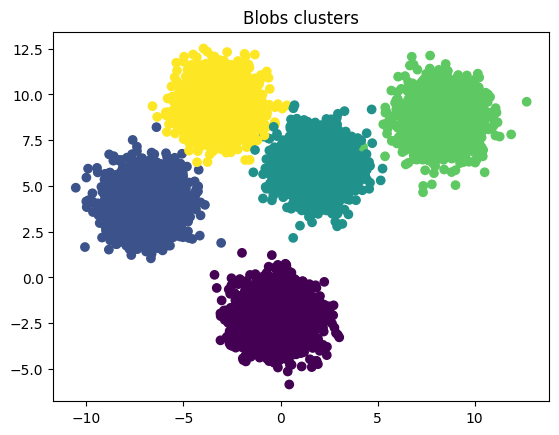

In [3]:
n_clusters = 5
X, y = make_blobs(n_samples=10000, centers=n_clusters, cluster_std=1)#, random_state=0)

labels, counts = np.unique(y, return_counts=True)

print(X.shape)
print(X[: 10])
print(y)

plt.scatter(X[:, 0], X[:, 1], c=y)
plt.title("Blobs clusters")
plt.show()

In [4]:
true_centroids = np.array([np.zeros(len(X[0])) for _ in range(n_clusters)])
for i in range(len(X)):
    true_centroids[y[i]] += X[i]
for k in range(n_clusters):
    true_centroids[k] /= counts[k]

print(true_centroids)

[[-0.24383713 -2.13808676]
 [-6.96319261  4.05727386]
 [ 1.87584574  5.9966584 ]
 [ 8.3007639   8.69079299]
 [-3.20177522  9.35827648]]


## Kmeans implementation

In [6]:
def dist(x1, x2):
    s = 0
    for i in range(len(x1)):
        s += (x1[i] - x2[i])**2
    return np.sqrt(s)

def dist_(x1, x2):
    return np.sqrt(np.sum((x1 - x2)**2))

def init_kmeans_pp(X, n_clusters):
    X = np.array(X)
    n_samples, _ = X.shape

    # Chooses first centroid randomly
    centroids = [X[random.randrange(n_samples)]]

    for _ in range(1, n_clusters):
        # Computes distances to the nearest centroid
        distances = np.array([min(np.sum((x - c)**2) for c in centroids) for x in X])

        # Defines proportionnal probabilities according to distances
        probabilities = distances / distances.sum()

        # Computes a new centroid
        cumulative_prob = np.cumsum(probabilities)
        r = random.random()
        for i, p in enumerate(cumulative_prob):
            if r < p:
                centroids.append(X[i])
                break

    return np.array(centroids)

[[ 1.88146291  5.99349068]
 [-6.96442425  4.05384162]
 [ 8.30244523  8.69285435]
 [-0.24383713 -2.13808676]
 [-3.20077189  9.35382428]]


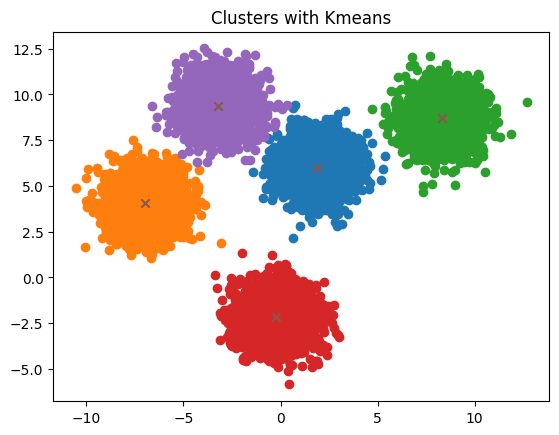

In [7]:
def kmeans_alamano(X, n_clusters, max_iter=300, tol=1e-6, init=None, debug=False):
    
    # Constants of the dataset
    n_samples, _ = X.shape
    d = len(X[0])

    # Initializes centroids
    if init == "kmean++":
        centroids = init_kmeans_pp(X, n_clusters)
    else:
        # Random initialization of centroids
        centroids = np.array([X[random.randrange(n_samples)] for _ in range(n_clusters)])
    prev_centroids = np.array([np.zeros(d) for _ in range(n_clusters)])

    # Iterations of Kmeans
    for iteration in range(max_iter):
    
        # Computes clusters according to the centroids
        clusters = [[] for _ in range(n_clusters)]
        for x_i in X:
            to_k = 0
            dist_min = np.inf
            for k in range(n_clusters):
                dist_to_k = dist(x_i, centroids[k])

                if debug :
                    print("dist_to_k < dist_min?", dist_to_k, dist_min, dist_to_k < dist_min)
                
                if dist_to_k < dist_min:
                    to_k = k
                    dist_min = dist_to_k
                
                    if debug :
                        print(dist_min)
            
            if debug :
                print(to_k)
            
            clusters[to_k].append(x_i)

        # Computes centroids
        for k in range(n_clusters):
            centroids_k = np.zeros(d)
            for x_ik in clusters[k]:
                centroids_k += x_ik
            centroids[k] = centroids_k/(len(clusters[k]) if len(clusters[k])>1 else 1)
            
        # Checks the convergence
        dist_centroids = 0
        for c_k, pc_k in zip(centroids, prev_centroids):
            dist_centroids += dist(c_k, pc_k)
        if dist_centroids < tol:

            if debug :
                print(iteration)
            
            break

        # Keeps previous centroids in memory
        prev_centroids = centroids.copy()
        # print(centroids)

    return centroids, clusters

centroids, clusters = kmeans_alamano(X, n_clusters, init="")
print(centroids)

# Plot clusters computed with Kmeans algorithm
for cluster in clusters:
    cluster = np.array(cluster)
    if len(cluster) > 0:  # Avoid empty clusters
        plt.scatter(cluster[:, 0], cluster[:, 1])
plt.scatter(centroids[:, 0], centroids[:, 1], marker = 'x')
plt.title("Clusters with Kmeans")
plt.show()

## Tests

#### Python with sklearn

Python sklearn time : 0.137099027633667
Python sklearn result : [[-3.20077189  9.35382428]
 [ 1.88146291  5.99349068]
 [ 8.30244523  8.69285435]
 [-0.24383713 -2.13808676]
 [-6.96442425  4.05384162]]


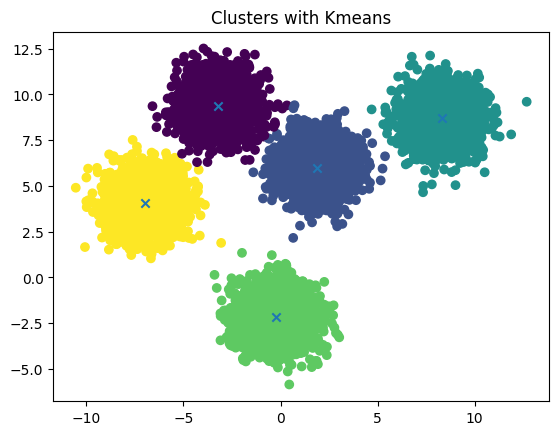

In [8]:
# Kmeans Python from sklearn
start = time.time()
kmeans = KMeans(n_clusters=n_clusters, init="k-means++")
model = kmeans.fit(X)
clusters_py_sk = model.predict(X)
centroids_py_sk = model.cluster_centers_
print("Python sklearn time :", time.time() - start)
print("Python sklearn result :", centroids_py_sk)

# Plot clusters computed with Kmeans algorithm
plt.scatter(X[:, 0], X[:, 1], c=clusters_py_sk)
plt.scatter(centroids_py_sk[:, 0], centroids_py_sk[:, 1], marker = 'x')
plt.title("Clusters with Kmeans")
plt.show()

#### Python manual implementation

Python scratch time : 4.637105941772461
Python scratch result : [[-3.20077189  9.35382428]
 [ 1.88146291  5.99349068]
 [-6.96442425  4.05384162]
 [ 8.30244523  8.69285435]
 [-0.24383713 -2.13808676]]


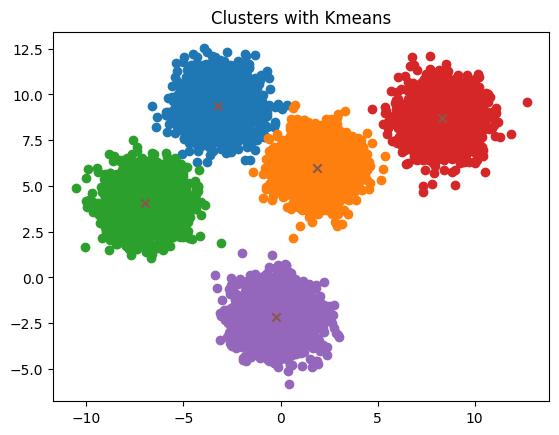

In [9]:
# Kmeans Python from scratch
start = time.time()
centroids_py_scratch, clusters_py_scratch = kmeans_alamano(X, n_clusters, init="kmeans++")
print("Python scratch time :", time.time() - start)
print("Python scratch result :", centroids_py_scratch)

# Plot clusters computed with Kmeans algorithm
for cluster in clusters_py_scratch:
    cluster = np.array(cluster)
    if len(cluster) > 0:  # Avoid empty clusters
        plt.scatter(cluster[:, 0], cluster[:, 1])
plt.scatter(centroids_py_scratch[:, 0], centroids_py_scratch[:, 1], marker = 'x')
plt.title("Clusters with Kmeans")
plt.show()

#### Rust with manual implementation

In [17]:
import rust_pyo3

In [ ]:
# Kmeans Rust from scratch
start = time.time()
centroids_rust = rust_pyo3.kmeans_alamano(X, n_clusters, max_tier=300, tol=1e-6, init="None", debug=False)
print("Rust scratch time :", time.time() - start)
print("Rust scratch result :", centroids_rust)

# Plot clusters computed with Kmeans algorithm
clusters = [[] for _ in range(n_clusters)]
for x_i in X:
    to_k = 0
    dist_min = np.inf
    for k in range(n_clusters):
        dist_to_k = dist(x_i, centroids[k])
        if dist_to_k < dist_min:
            to_k = k
            dist_min = dist_to_k
clusters[to_k].append(x_i)

for cluster in clusters_py_scratch:
    cluster = np.array(cluster)
    if len(cluster) > 0:  # Avoid empty clusters
        plt.scatter(cluster[:, 0], cluster[:, 1])
plt.scatter(centroids_py_scratch[:, 0], centroids_py_scratch[:, 1], marker = 'x')
plt.title("Clusters with Kmeans")
plt.show()

TypeError: kmeans_alamano() missing 4 required positional arguments: 'max_iter', 'tol', 'init', and 'debug'